# 数据预处理

In [1]:
import os
import h5py
import shutil
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda
from keras.models import Model

Using TensorFlow backend.


## 下载并解压数据

In [2]:
url_train = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1515759879&Signature=SGTFF%2B17%2Fct9MKavEZSeMaYE5yPfQYoHhKy7fR%2BUH%2BVbdip1q9aiRRap8yb%2Bch1j%2Fs5baMv625REXpuLNFt8xM6E%2FLL8cVpIcAH%2FWKaZ%2BV4JJhbNdIev%2BvEPQXK4XCWcYA38cyvZ5Nf359UG2Zdt2dXfGVixL9COCFStMX9yABlzcq85p2fVahkEmYPsJ3xM%2Bv5TQyZIYGhpN9MgWFd2WYeHd0RbhwQBNyaa6rMKIPl2V2jur250rBe8MH5ZHMR7fItze4JfIDLc4%2FkYSe0HQjF3wKMY9PI4GUIgw0A%2FNetEGzsyQtDdrrgJXIkR9eqsQPf%2F3lMZMFmjOrZ%2BdXD1Aw%3D%3D'
url_test = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1515759876&Signature=qxmLQ5zcvY0DvyW8Vh82saLY14JObfR9zmH87IXym512LjmgpQlzXxyqxvz0zRL5Ns1acy%2BIYRKk4Z2q7Wv2pu5Blgj6OX%2BP%2BWytMDxywwnHCNLRIPwQLyiAu%2BROgtHtoP9p3UMh4wI1A2OGsrqDzvIAfI4TSA%2BS%2BAf2UdkXcyWK7jTdaAdKJOx71fnR%2BEN8SU4BbTq%2BmAE0Y6l%2F2CKifSbAME%2BYPqPzqLRNrYgjXU9jIEFJ7JtNRwvlnNQQRMsXO3HwX%2BjfeEoIBiLn9x8wsSSB5hpLnhV9W4Ze7GGXbJcG1kcB3s2oHhKMdQiyX8Kp4WbE9VVF6ZF%2BeVeT6bWiug%3D%3D'

train_path = "train.zip"
test_path = "test.zip"
#下载图片
def Download_data(url,path):
    r = requests.get(url) 
    with open(path, "wb") as code:
         code.write(r.content)

#解压图片
def Un_zip(file_name):  
    """unzip zip file"""  
    zip_file = zipfile.ZipFile(file_name)  
    for names in zip_file.namelist():  
        zip_file.extract(names)  
    zip_file.close() 

Download_data(url_train,train_path)
Download_data(url_test,test_path)
print("下载完成！")

Un_zip(train_path)
Un_zip(test_path)
print("解压完成！")

下载完成！
解压完成！


## 图片分类

In [4]:
train_filenames = os.listdir('train')
test_filenames = os.listdir('test')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

print "捕获"+str(len(train_cat))+"只猫咪！！！"
print "捕获"+str(len(train_dog))+"只狗狗！！！"

def create_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

def file_move(data,old_dir,new_dir):
    for filename in data:
        shutil.move(old_dir+filename, new_dir+filename)   

cat_path = 'train_image/cat/'
dog_path = 'train_image/dog/'

create_mkdir('train_image')
os.mkdir(cat_path)
os.mkdir(dog_path)

create_mkdir('test_image')
create_mkdir('test_image/test')

file_move(train_cat,'train/',cat_path)
file_move(train_dog,'train/',dog_path)
file_move(test_filenames,'test/','test_image/test/') 
    
shutil.rmtree("test")
shutil.rmtree("train")
print("分类完成！")

捕获12500只猫咪！！！
捕获12500只狗狗！！！
分类完成！


## 显示图片样本

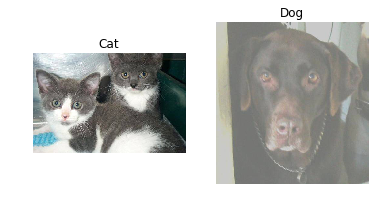

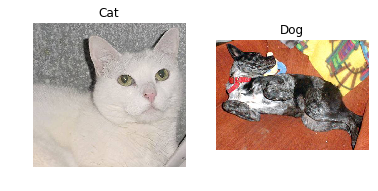

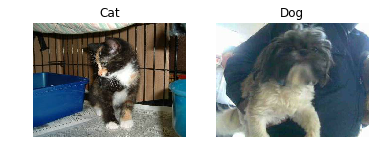

In [5]:
#显示猫和狗的图像
file_cat = os.listdir(cat_path)
files_dog = os.listdir(dog_path)
for i in range(3):
    image_cat = mpimg.imread(cat_path+file_cat[np.random.randint(0,12500)])
    image_dog = mpimg.imread(dog_path+files_dog[np.random.randint(0,12500)])

    plt.subplot(1,2,1)
    plt.title('Cat')
    plt.imshow(image_cat)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Dog')
    plt.imshow(image_dog)
    plt.axis('off')
    plt.show()

## 数据清洗

In [2]:
#导入图片并将图片大小统一
generator = image.ImageDataGenerator()
train_generator = generator.flow_from_directory("train_image", (299,299), shuffle=False, 
                                          batch_size=16)

Found 25000 images belonging to 2 classes.


In [3]:
input_tensor = Input((299, 299, 3))
#将图片归一化
input_tensor = Lambda(preprocess_input)(input_tensor)
#导入预训练InceptionV3模型
base_model = InceptionV3(input_tensor=input_tensor,weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(base_model.input, x)

X_train = model.predict_generator(train_generator, train_generator.nb_sample)
y_train=train_generator.classes

input_tensor = Input(X_train.shape[1:])
x = Dense(1024, activation='relu')(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])

In [4]:
model.fit(X_train, y_train, batch_size=128, nb_epoch=5, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 1s - loss: 0.0364 - acc: 0.9873 - val_loss: 0.0278 - val_acc: 0.9908

In [5]:
train_pred = model.predict(X_train, verbose=1)

cat_clean = []
dog_clean = []
for i in range(0,len(train_pred)):
    if i <12500 :
        if train_pred[i][0] > 0.5:
            cat_clean.append('train2/cat/cat.'+str(i)+'.jpg')
    else:
        if train_pred[i][0] <0.5:
            dog_clean.append('train2/dog/dog.'+str(i-12500)+'.jpg')

24608/25000 [============================>.] - ETA: 0s  

In [6]:
print '******猫咪明显错误分类地址******'
for cat_path in cat_clean:
    print cat_path
print '共' + str(len(cat_clean)) + '只猫咪明显分类错误'

print '\n\n******狗狗明显错误分类地址******'
for dog_path in dog_clean:
    print dog_path
print '共' + str(len(dog_clean)) + '只狗狗明显分类错误'

******猫咪明显错误分类地址******
train2/cat/cat.919.jpg
train2/cat/cat.2751.jpg
train2/cat/cat.7156.jpg
共3只猫咪明显分类错误


******狗狗明显错误分类地址******
train2/dog/dog.363.jpg
train2/dog/dog.1943.jpg
train2/dog/dog.7450.jpg
train2/dog/dog.7554.jpg
train2/dog/dog.7702.jpg
train2/dog/dog.7819.jpg
train2/dog/dog.7841.jpg
train2/dog/dog.7983.jpg
train2/dog/dog.8069.jpg
train2/dog/dog.8177.jpg
train2/dog/dog.8392.jpg
train2/dog/dog.8471.jpg
train2/dog/dog.8566.jpg
train2/dog/dog.8696.jpg
train2/dog/dog.8731.jpg
train2/dog/dog.9219.jpg
train2/dog/dog.9281.jpg
train2/dog/dog.9392.jpg
train2/dog/dog.9433.jpg
train2/dog/dog.9867.jpg
train2/dog/dog.9889.jpg
train2/dog/dog.9988.jpg
train2/dog/dog.10139.jpg
train2/dog/dog.10251.jpg
train2/dog/dog.10993.jpg
train2/dog/dog.11043.jpg
train2/dog/dog.11148.jpg
train2/dog/dog.11231.jpg
train2/dog/dog.11264.jpg
train2/dog/dog.11294.jpg
train2/dog/dog.11472.jpg
train2/dog/dog.11504.jpg
train2/dog/dog.11800.jpg
train2/dog/dog.11907.jpg
train2/dog/dog.12033.jpg
train2/dog/dog.12

**通过对分类中明显错误的图片进行人为识别，并没有标签错误的图片。所以图片不需要额外清理。**